In [315]:
from random import random
from copy import deepcopy
from math import exp, log, sqrt, tanh, atan, pi
from matplotlib import pyplot as plt
from typing import List, Tuple
import random
import csv
from enum import Enum
from copy import deepcopy

# Helper functions

In [316]:
def sigmoid(x: float) -> float:
    if x >= 0:
        return 1 / (1 + exp(-x)) 
    else:
        return exp(x) / (1 + exp(x))

In [317]:
def dot(a: List[float], b: List[float]) -> float:
    assert len(a) == len(b)
    return sum([a_i * b_i for a_i, b_i in zip(a, b)])

In [318]:
def step(x: float) -> float:
    if x >= 0:
        return 1 - 1e-10
    else:
        return 1e-10

In [319]:
def hypertan(x: float) -> float:
    return (tanh(x) + 1) / 2

In [320]:
def activate(x: List[float], weights: List[float]) -> float:
    assert len(weights) == len(x)
    return sigmoid(dot(weights, x))

# Loss function

In [321]:
def log_likelihood(y_true: float, y_predicted: float) -> float:
    return -((y_true * log(y_predicted + 1e-14)) + ((1 - y_true) * log(1 - y_predicted + 1e-14)))

In [322]:
def compute_loss(ys_true: List[float], ys_pred: List[float]) -> float:
    assert len(ys_true) == len(ys_pred)
    return sum([log_likelihood(y_true, y_pred) for y_true, y_pred in zip(ys_true, ys_pred)]) / len(ys_true)

# Gradient descent

In [323]:
def compute_gradients(xs, ys, weights):
    gradients = [0 for _ in range(len(weights))]
    for x, y in zip(xs, ys):
        err = activate(x, weights) - y
        for i, x_i in enumerate(x):
            gradients[i] += (err * x_i)
    gradients = [1 / len(x) * g for g in gradients]
    return gradients

In [324]:
def train(xs, ys, epochs, learn_rate = 0.01):
    weights = [0 for _ in range(len(xs[0]))]
    loss_history = []
    for epoch in range(epochs):
        ys_pred = [activate(x, weights) for x in xs]
        loss = compute_loss(ys, ys_pred)
        loss_history.append(loss)
        
        gradients = compute_gradients(xs, ys, weights)
        weights = [weight - learn_rate * change for weight, change in zip(weights, gradients)]
    return weights, loss_history

# Testing on points

In [325]:
def random_on_rect(span_x: Tuple[int, int], span_y: Tuple[int, int], total: int) -> List[float]:
    return [[random.uniform(*span_x), random.uniform(*span_y)] for _ in range(total)]

In [326]:
def get_classification(points: List[Tuple[float, float]], slope: float, constant: float) -> List[int]:
    def classify_point(point):
        x, y = point
        if y >= slope * x + constant:
            return 1
        else:
            return 0
    return np.array([classify_point(point) for point in points])

def split_into_classes(points: List[Tuple[float, float]], classifications: List[int]):
    above, below = [], []
    for point, classification in zip(points, classifications):
        if classification == 1:
            above.append(point)
        elif classification == 0:
            below.append(point)
    return above, below

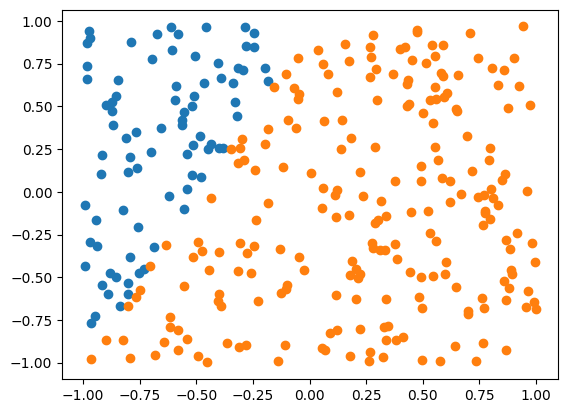

In [327]:
slope = 2
bias = 1

xs = random_on_rect((-1, 1), (-1, 1), 300)
ys = get_classification(xs, slope, bias)
show_classified(xs, ys)

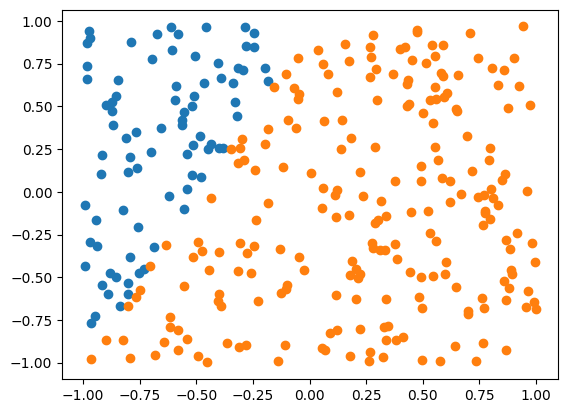

In [328]:
for x in xs: # Note that this is added to simulate a bias value
    x.insert(0, 1)

weights, loss_history = train(xs, ys, 150)
ys_pred = [1 if activate(x, weights) > 0.5 else 0 for x in xs]

for x in xs: # and then is promptly removed for the points to be correctly rendered
    x.pop(0)
    
above, below = split_into_classes(xs, ys)
plt.scatter(*zip(*above))
plt.scatter(*zip(*below))
plt.show()

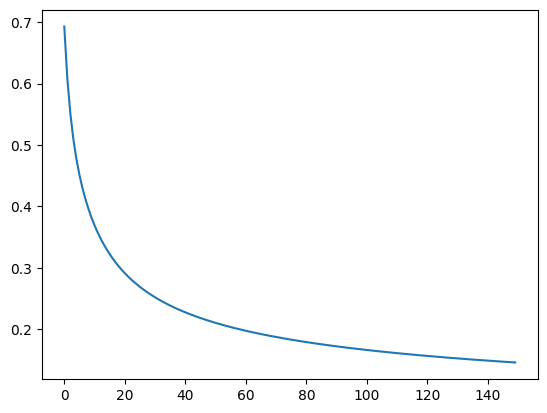

In [329]:
plt.plot(loss_history)
plt.show()

# Real data
Functions below work with the provided data to remove categorical types of data, standardize it and finally train the model. 

In [330]:
class FeatureType(Enum):
    Numerical = 1
    Category = 2

## De-categorising data
Some feaures such as sex and chest pain type are discreete cathegory features. We'd like to separate them into unique features that take on a value of 0 if data in the original feature isnt of this category and take on a value of 1 if it is of this category.

### Data manipulation helper functions
Functions below are used to manipulate data only once and are inconsequential to the algorithm.

In [331]:
def get_possible_feature_values(data, index):
    possible_values = []
    for row in data:
        for i, feature in enumerate(row):
            if i == index:
                possible_values.append(feature)
    return list(set(possible_values))

def find_among_possible(possible_values, value):
    return possible_values.index(value)

def find_possible_values_for_all(data, descriptor):
    possible_values = []
    for i, feature_type in enumerate(descriptor):
        if feature_type == FeatureType.Category:
            possible_values.append(get_possible_feature_values(data, i))
        else:
            possible_values.append(None)
    return possible_values

def add_category_to_data_point(data_point, feature, possible_values):
    index = find_among_possible(possible_values, feature)
    result = [0 for _ in possible_values]
    result[index] = 1
    return data_point + result

### Data loading functions
These functions load data and manipulate it in such a way that it can be used in the model

In [332]:
def get_default_descriptor():
    default_descriptor = [FeatureType.Numerical for _ in range(14)]
    default_descriptor[1] = FeatureType.Category # Sex
    default_descriptor[2] = FeatureType.Category # Chest pain type
    default_descriptor[5] = FeatureType.Category # fasting blood sugar > 120 mg/dl
    default_descriptor[8] = FeatureType.Category # exercise induced angina
    return default_descriptor

def read_raw_data(file_path):
    with open(file_path, newline='' ) as file:
        reader = csv.reader(file, delimiter=',')
        names = next(reader)
        raw_data = list(reader)
    return raw_data, names

def get_data(file_path, descriptor):
    raw_data, _ = read_raw_data(file_path)
    possible_values = find_possible_values_for_all(raw_data, descriptor)
    xs = []
    ys = []
    for row in raw_data:
        data_point = []
        for i, (feature, feature_type) in enumerate(zip(row, descriptor)):
            if feature_type == FeatureType.Numerical:
                data_point.append(float(feature))
            elif feature_type == FeatureType.Category:
                data_point = add_category_to_data_point(data_point, feature, possible_values[i])
        out = data_point.pop()
        ys.append(out)
        xs.append(data_point)
    return xs, ys

## Implementing z-score

In [333]:
def z_score(data: List[List[float]]) -> List[List[float]]:
    def mean(data: List[float]) -> float:
        return sum(data) / len(data)

    def standard_deviation_sample(data: List[float]) -> float:
        mu = mean(data)
        return sqrt(1 / (len(data) - 1) * sum([(item - mu) ** 2 for item in data]))

    data_copy = deepcopy(data)
    data_transposed = list(zip(*data_copy))
    mus = [] # Population means
    stds = [] # Standard deviations
    for item in data_transposed:
        mus.append(mean(list(item)))
        stds.append(standard_deviation_sample(list(item)))

    for item in data_copy:
        mu = mean(item)
        std = standard_deviation_sample(item)
        for i, elem in enumerate(item):
            if stds[i] > 0.0:
                item[i] = (elem - mus[i]) / stds[i]

    return data_copy

## Evaluating results

In [334]:
def evaluate(ys_true, ys_pred, threshold = 0.5):
    total = len(ys)
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    for y_true, y_pred in zip(ys_true, ys_pred):
        if y_true == 1 and y_pred == 1:
            true_positives += 1
        elif y_true == 0 and y_pred == 0:
            true_negatives += 1
        elif y_true == 1 and y_pred == 0:
            false_negatives += 1
        elif y_true == 0 and y_pred == 1:
            false_positives += 1
    
    print("True Positives: {}".format(true_positives))
    print("True Negatives: {}".format(true_negatives))
    print("False Positives: {}".format(false_positives))
    print("False Negatives: {}".format(false_negatives))
    print("Accuracy: {}".format((true_positives + true_negatives) / total))
    print("Error rate: {}".format((false_positives + false_negatives) / total))

In [335]:
xs, ys = get_data("data/heart.csv", get_default_descriptor())
xs = z_score(xs)
for x in xs: # Again, this is added to simulate a bias value
    x.insert(0, 1)

True Positives: 151
True Negatives: 108
False Positives: 30
False Negatives: 14
Accuracy: 0.8547854785478548
Error rate: 0.14521452145214522


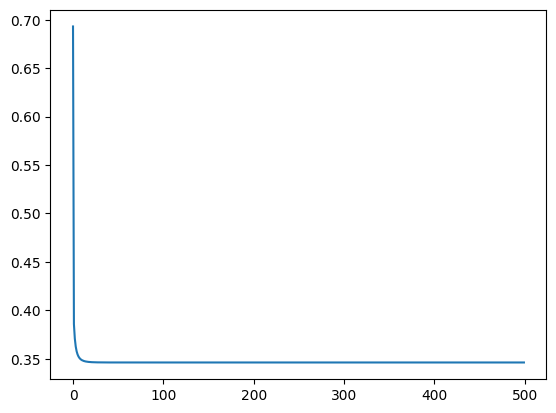

In [336]:
weights, loss_history = train(xs, ys, epochs=500, learn_rate = 0.1)
ys_pred = [1 if activate(x, weights) > 0.5 else 0 for x in xs]
evaluate(ys, ys_pred)

plt.plot(loss_history)
plt.show()